# **Aprendizado Profundo para Reconhecimento Visual**
#### Universidade Federal de São Carlos (UFSCar) - campus Sorocaba
#### Projeto prático

**Integrantes**:<br>
Giovanna Aguiar de Castro<br>
Matheus Vargas Volpon Berto

**Professor responsável**:<br>
Prof. Dr. Jurandy Gomes de Almeida Júnior

**Atribuições**  

Este projeto foi realizado a partir de uma base de dados previamente existente no Kaggle, disponível através [deste link](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small). Além disso, parte dos códigos executados neste notebook, especialmente ao que se refere à análise exploratória, podem ter sido aproveitados de trabalhos já realizados e publicamente disponíveis, estando alguns principais listados abaixo:
    
1. [Base/Denoising Autoencoder + Dimension Reduction](https://www.kaggle.com/code/ohseokkim/base-denoising-autoencoder-dimension-reduction)
2. [The prediction of color tags](https://www.kaggle.com/code/rrighart/the-prediction-of-color-tags)
3. [Fashion Product Images Classifier](https://www.kaggle.com/code/paramaggarwal/fashion-product-images-classifier)

## Configurações de recursos

### Bibliotecas e pacotes

In [10]:
%pip install tensorflow --quiet
%pip install ydata-profiling --quiet
%pip install opencv-python --quiet
%pip install shap --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [121]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import os, cv2, shap, warnings
from math import ceil

from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from skimage.segmentation import slic
from IPython.display import Image, display

import tensorflow as tf
import keras
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_v2_preprocess, decode_predictions as mobilenetv2_decode
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_v3_preprocess, decode_predictions as inceptionv3_decode
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, dot, Reshape, Flatten

In [9]:
print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.15.0


### Constantes

In [140]:
#DATASET_PATH = "/content/drive/MyDrive/UFSCAR/23-2/APRENDIZADO PROFUNDO/TRABALHO/kaggle-dataset/"
#DATASET_PATH = "/Users/giovannacastro/Documents/DRIVE-PESSOAL/UFSCAR/23-2/APRENDIZADO PROFUNDO/TRABALHO/kaggle-dataset 2/"
DATASET_PATH = '../data/kaggle-dataset/'
OUTPUT_IMAGES_PATH = '../imgs/'
BATCH_SIZE = 32
IMG_SIZE = (80, 60)
TEST_IMAGES_IDS = [40524, 44188, 56314, 58621]

### Funções

In [105]:
def plot_figures(figures, nrows=1, ncols=1, figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()

def img_path(img, folder='train', format='jpg'):
    """Returns the path of an image inside the folder of training samples.

    Parameters
    ----------
    img : filename
    """

    return DATASET_PATH + folder + "/" + str(img) + '.' + format

def load_image(img):
    """Load and image given it path.

    Parameters
    ----------
    img : filename
    """

    return cv2.imread(img_path(img))

def load_images_from_folder(folder):
    """Load all images present in a given folder.

    Parameters
    ----------
    folder : path of thr folder that contains the images    
    """

    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            images.append(img)
    return images

def load_images_from_list(names_list):
    """Load all images present in a given list of filenames.

    Parameters
    ----------
    names_list : list with the filenames    
    """

    images = []
    for filename in names_list:
        img = cv2.imread(DATASET_PATH + '/test_images/{}'.format(filename))
        if img is not None:
            images.append(img)

    return images

def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out



def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

def train_mobilenet_v2(df_train, target_size):
    image_generator = ImageDataGenerator(
        validation_split=0.2
    )

    training_generator = image_generator.flow_from_dataframe(
        dataframe=df_train,
        directory=DATASET_PATH + "train",
        x_col="image",
        y_col="subCategory",
        target_size=target_size,
        batch_size=BATCH_SIZE,
        subset="training"
    )

    validation_generator = image_generator.flow_from_dataframe(
        dataframe=df_train,
        directory=DATASET_PATH + "train",
        x_col="image",
        y_col="subCategory",
        target_size=target_size,
        batch_size=BATCH_SIZE,
        subset="validation"
    )

    classes = len(training_generator.class_indices)

    base_model = MobileNetV2(input_shape=target_size+(3,), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    model.fit(
        x=training_generator,
        #steps_per_epoch=ceil(0.8 * (df_train.size / BATCH_SIZE)),

        validation_data=validation_generator,
        validation_steps=ceil(0.2 * (df_train.size / BATCH_SIZE)),

        epochs=10,
        verbose=1
    )

    model.save('../models/mobilenet_v2_{}x{}_fashion.h5'.format(target_size[0], target_size[1]))
    return model

def train_inception_v3(df_train, target_size):
    image_generator = ImageDataGenerator(
        validation_split=0.2
    )

    training_generator = image_generator.flow_from_dataframe(
        dataframe=df_train,
        directory=DATASET_PATH + "train",
        x_col="image",
        y_col="subCategory",
        target_size=target_size,
        batch_size=BATCH_SIZE,
        subset="training",
        preprocessing_function=inception_v3_preprocess,
    )

    validation_generator = image_generator.flow_from_dataframe(
        dataframe=df_train,
        directory=DATASET_PATH + "train",
        x_col="image",
        y_col="subCategory",
        target_size=target_size,
        batch_size=BATCH_SIZE,
        subset="validation",
        preprocessing_function=inception_v3_preprocess,
    )

    classes = len(training_generator.class_indices)

    input_target = Input((299, 299, 3))
    base_model = InceptionV3(input_shape=target_size+(3,), include_top=False, weights='imagenet', pooling='avg', input_tensor=input_target)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(classes, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    model.fit(
        x=training_generator,
        #steps_per_epoch=ceil(0.8 * (df_train.size / BATCH_SIZE)),

        validation_data=validation_generator,
        validation_steps=ceil(0.2 * (df_train.size / BATCH_SIZE)),

        epochs=5,
        verbose=1
    )

    model.save('../models/inception_v3_{}x{}_fashion.h5'.format(target_size[0], target_size[1]))
    return model

def shap_interpretability(file_id, model, model_name, preprocessing_function):
    def f(z):
        return model.predict(preprocessing_function(mask_image(z, segments_slic, img_orig, 255)))

    file ="../data/kaggle-dataset/test/{}.jpg".format(file_id)

    CLASS_NAMES = list(df_train['subCategory'].unique())
    classes =  [str(x) for x in range(0, len(CLASS_NAMES))]
    mapping = dict(zip(classes, CLASS_NAMES))

    for key, value in mapping.items():
        mapping[key] = ['', value]

    img = image.load_img(file, target_size=(96, 96))
    img_orig = image.img_to_array(img)

    segments_slic = slic(np.array(img), compactness=1, sigma=3)

    explainer = shap.KernelExplainer(f, np.zeros((1,50)))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

    preds = model.predict(preprocessing_function(np.expand_dims(img_orig.copy(), axis=0)))
    top_preds = np.argsort(-preds)
    inds = top_preds[0]

    colors = []
    for l in np.linspace(1,0,100):
        colors.append((245/255,39/255,87/255,l))
    for l in np.linspace(0,1,100):
        colors.append((24/255,196/255,93/255,l))
        
    cm = LinearSegmentedColormap.from_list("shap", colors)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    fig.suptitle("{} classifier".format(model_name))
    axes[0].imshow(img)
    axes[0].axis('off')
    max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
    for i in range(1):
        m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
        axes[i+1].set_title(mapping[str(inds[i])][1])
        axes[i+1].imshow(img.convert('LA'), alpha=0.15)
        im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
        axes[i+1].axis('off')
    cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
    cb.outline.set_visible(False)
    plt.title(mapping[str(inds[0])][1])
    plt.savefig(OUTPUT_IMAGES_PATH + 'shap_plot_' + str(file_id) + '_' + ''.join(model_name.lower().split(' ')) + '_' + ''.join(mapping[str(inds[0])][1].split(' ')).lower() + '.jpg')
    plt.show()

def gradcam_interpretability(file_id, model, model_name, preprocessing_function, img_size):
    filepath = img_path(file_id, folder='test')

    CLASS_NAMES = list(df_train['subCategory'].unique())
    classes =  [str(x) for x in range(0, len(CLASS_NAMES))]
    mapping = dict(zip(classes, CLASS_NAMES))

    for key, value in mapping.items():
        mapping[key] = ['', value]

    def get_img_array(filepath, size):
        ## `img` is a PIL image 
        img = keras.utils.load_img(filepath, target_size=size)
        array = keras.utils.img_to_array(img)
        ## We add a dimension to transform our array into a "batch"
        array = np.expand_dims(array, axis=0)
        return array

    def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        ## First, we create a model that maps the input image to the activations
        ## of the last conv layer as well as the output predictions
        grad_model = keras.models.Model(
            model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
        )

        ## Then, we compute the gradient of the top predicted class for our input image
        ## for the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        ## We are doing transfer learning on last layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        ## This is a vector where each entry is the mean intensity of the gradient
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        ## calculates a heatmap highlighting the regions of importance in an image
        ## for a specific 
        ## predicted class by combining the output of the last convolutional layer
        ## with the pooled gradients.
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        ## For visualization purpose
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()
    
    ## Preparing the image
    img_array = preprocessing_function(get_img_array(filepath, size=img_size))

    ## Remove last layer's softmax(transfer learning)
    model.layers[-1].activation = None

    preds = model.predict(img_array)
    top_preds = np.argsort(-preds)
    inds = top_preds[0]

    # Iterando reversamente sobre as camadas para encontrar a última camada de convolução
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break

    ## Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    ## visulization of heatmap
    #plt.matshow(heatmap)
    #plt.show()

    def save_and_display_gradcam(filepath, heatmap, alpha=0.4):
        ## Loading the original image
        img = keras.utils.load_img(filepath)
        img = keras.utils.img_to_array(img)

        ## Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        ## Use jet colormap to colorize heatmap
        jet = matplotlib.colormaps["jet"]

        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        ## Create an image with RGB colorized heatmap
        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap)

        ## Superimpose the heatmap on original image
        Superimposed_img = jet_heatmap * alpha + img
        Superimposed_img = keras.utils.array_to_img(Superimposed_img)

        ## Save the superimposed image
        cam_path = OUTPUT_IMAGES_PATH + "camgrad_plot_" + str(file_id) + '_' + ''.join(model_name.lower().split(' ')) + '_' + mapping[str(inds[0])][1].lower() + '.jpg'
        Superimposed_img.save(cam_path)

        ## Displaying Grad CAM
        display(Image(cam_path))


    save_and_display_gradcam(filepath, heatmap)

## Preparação de dados

In [13]:
df = pd.read_csv(DATASET_PATH + "styles.csv", on_bad_lines='skip')
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)

In [14]:
print('A pasta de teste já existe e contém pelo menos um arquivo png. Os DataFrames de treino e teste serão criados a partir das imagens das pastas existentes')
arquivos_jpg_teste = [arquivo for arquivo in os.listdir(DATASET_PATH + 'test/') if arquivo.lower().endswith(".jpg")]
df_test = df[df['image'].isin(arquivos_jpg_teste)]
df_test = df_test.reset_index(drop=True)

A pasta de teste já existe e contém pelo menos um arquivo png. Os DataFrames de treino e teste serão criados a partir das imagens das pastas existentes


In [15]:
df_train = df.merge(df_test, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
print('Quantidade de amostras para treinamento: {}'.format(len(df_train.index)))
print('Quantidade de amostras para teste: {}'.format(len(df_test.index)))

Quantidade de amostras para treinamento: 44379
Quantidade de amostras para teste: 45


## Análise exploratória

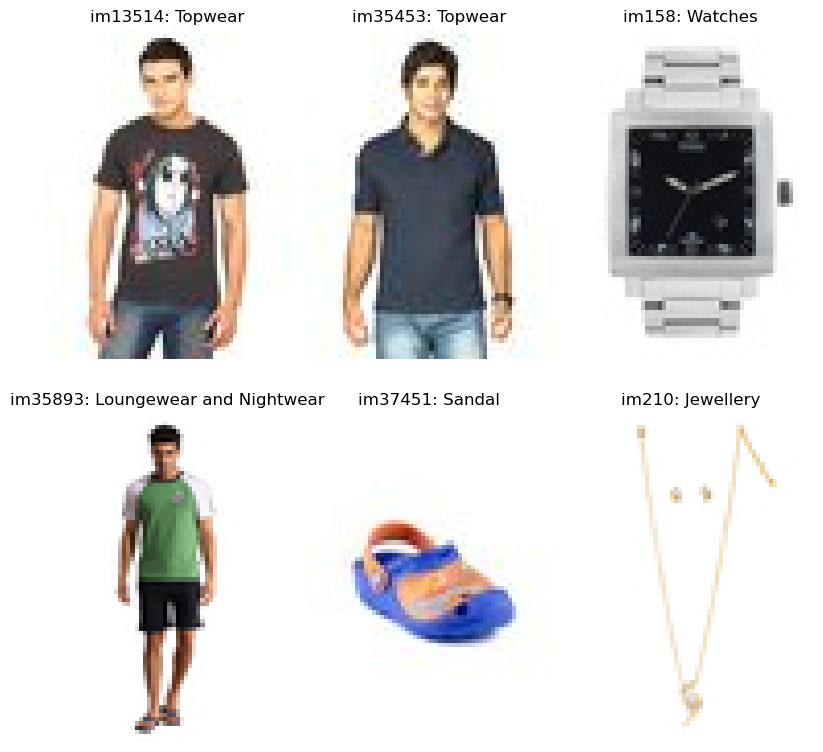

In [39]:
figures = {'im'+str(i)+': {}'.format(row.subCategory): load_image(row.image) for i, row in df_train.sample(6).iterrows()}
plot_figures(figures, 2, 3)

In [14]:
profile = ProfileReport(df_train, title='Automobile data', html={'style': {'full_width': True}})
profile.to_notebook_iframe()
profile.to_file("../docs/kaggle_dataset_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Transferência de aprendizado a partir de modelos pré-treinados

### MobileNet V2

In [589]:
mobilenet_v2_model = train_mobilenet_v2(df_train, target_size=(96, 96))

Found 35500 validated image filenames belonging to 45 classes.


Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.


Found 8874 validated image filenames belonging to 45 classes.


Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.


### Inception V3

In [ ]:
inception_v3_model = train_inception_v3(df_train, target_size=(299, 299))

## Análise de interpretabilidade com SHAP

### MobileNet V2

In [ ]:
for image_id in TEST_IMAGES_IDS:
    shap_interpretability(image_id, mobilenet_v2_model, 'MobileNet V2', mobilenet_v2_preprocess)

### Inception V3

In [ ]:
for image_id in TEST_IMAGES_IDS:
    shap_interpretability(image_id, inception_v3_model, 'Inception V3', inception_v3_preprocess)

## Análise de interpretabilidade com Grad-CAM

### MobileNet V2

1/1 [==============================] - 0s 64ms/step


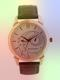

1/1 [==============================] - 0s 71ms/step


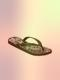

1/1 [==============================] - 0s 55ms/step


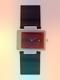

1/1 [==============================] - 0s 80ms/step


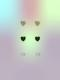

In [143]:
for image_id in TEST_IMAGES_IDS:
    gradcam_interpretability(image_id, mobilenet_v2_model, 'MobileNet V2', mobilenet_v2_preprocess, mobilenetv2_decode, (96, 96))

### Inception V3

In [ ]:
for image_id in TEST_IMAGES_IDS:
    gradcam_interpretability(image_id, inception_v3_model, 'Inception V3', inception_v3_preprocess, (299, 299))